In [ ]:
try:
    import openfermion
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion --quiet

#you can ignore the tf error

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 541 kB 40.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:
from openfermion.ops import FermionOperator

my_term = FermionOperator(((3, 1), (1, 0)))
print(my_term)

my_term = FermionOperator('3^ 1')
print(my_term)

a3 = FermionOperator('3')
print(a3)

# add operators
op1 = FermionOperator( ((3,1), (2,1), (1,0)) , 3. + 2.j)
op2 = FermionOperator(((2,0), (4,1)), 1j)
op3 = FermionOperator(((2,0), (4,1)), 2j)
#inefficient sum: a copy of the summed objects is created. op1 += op2 is more efficient
op = op1 + op2 + op3
print(op)

1.0 [3^ 1]
1.0 [3^ 1]
1.0 [3]
3j [2 4^] +
(3+2j) [3^ 2^ 1]


Nel prossimo jw, interessante il metodo eigenspectrum che funziona anche sull'operatore fermionico di partenza.

In [ ]:
#Jordan Wigner
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.linalg import eigenspectrum

op = FermionOperator('1^ 1 3^')
op += hermitian_conjugated(op)
print(op)

jw_op = jordan_wigner(op)
print('')
print(jw_op)
jw_spectrum = eigenspectrum(jw_op)
print(jw_spectrum)

print(eigenspectrum(op))

from openfermion.transforms import reverse_jordan_wigner
rev = reverse_jordan_wigner(jw_op)
print(rev)

1.0 [1^ 1 3^] +
1.0 [3 1^ 1]

(0.5+0j) [Z0 Z1 Z2 X3] +
(-0.5+0j) [Z0 Z2 X3]
[-1. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
[-1. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
(1+0j) [3 1^ 1] +
(1+0j) [3^ 1^ 1]


https://quantumai.google/openfermion/fqe/tutorials/fermi_hubbard

In [ ]:
#do the fermi hubbard Hamiltonian

In [ ]:
import openfermion as of

N = 4
U = 2.0
J = -1.0

hubbard = of.fermi_hubbard(
    1, N, tunneling = -J, coulomb = U, periodic = False
    )
print(hubbard)

2.0 [0^ 0 1^ 1] +
-1.0 [0^ 2] +
-1.0 [1^ 3] +
-1.0 [2^ 0] +
2.0 [2^ 2 3^ 3] +
-1.0 [2^ 4] +
-1.0 [3^ 1] +
-1.0 [3^ 5] +
-1.0 [4^ 2] +
2.0 [4^ 4 5^ 5] +
-1.0 [4^ 6] +
-1.0 [5^ 3] +
-1.0 [5^ 7] +
-1.0 [6^ 4] +
2.0 [6^ 6 7^ 7] +
-1.0 [7^ 5]


In [ ]:
op = FermionOperator( ((1,1), (2,0)), coefficient = J )
#fare ciclo for per riprodurre l'Hamiltoniana. Poi della trotterization guarderemo i circuiti
#lo spin è un settore di superselezione: l'hopping avviene solo tra qubits con stesso spin, nel vecchio notebook i primi 8 vs altri 8, a volte i pari vs dispari

N = 4
N_qubits = 2 * N
J = 1
#devo usare N - 1: ho 0, 1 ,.. ,N -1 per fare N qubits. Raddoppiati per fare spin down
for i in range(N_qubits - 2):
  print( 
      FermionOperator(
                      ((i,1), (i+1,0)), coefficient = J
                      ) 
      )
  
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+1,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]
print(H_J)

U = 1.
H_U = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0), (i+N, 1), (i+N,0)), coefficient = U  
               )
          for i in range(N)
       )
]
print(H_U)
#H_U è una lista di operatori, da sommare tutti
print(sum(H_U))

1 [0^ 1]
1 [1^ 2]
1 [2^ 3]
1 [3^ 4]
1 [4^ 5]
1 [5^ 6]
[-1 [0^ 1] +
-1.0 [1^ 0], -1 [1^ 2] +
-1.0 [2^ 1], -1 [2^ 3] +
-1.0 [3^ 2], -1 [3^ 4] +
-1.0 [4^ 3], -1 [4^ 5] +
-1.0 [5^ 4], -1 [5^ 6] +
-1.0 [6^ 5]]
[1.0 [0^ 0 4^ 4], 1.0 [1^ 1 5^ 5], 1.0 [2^ 2 6^ 6], 1.0 [3^ 3 7^ 7]]
1.0 [0^ 0 4^ 4] +
1.0 [1^ 1 5^ 5] +
1.0 [2^ 2 6^ 6] +
1.0 [3^ 3 7^ 7]


In [ ]:
#His hubbard, number operator is made spin up spin down, so his even sites are spin up and odd are spin down
"""Define the Hamiltonian."""
# Parameters.
nsites = 4
U = 1.0
J = -1.0

hubbard = of.fermi_hubbard(1, nsites, tunneling=-J, coulomb=U, periodic=False)
print(hubbard)

1.0 [0^ 0 1^ 1] +
-1.0 [0^ 2] +
-1.0 [1^ 3] +
-1.0 [2^ 0] +
1.0 [2^ 2 3^ 3] +
-1.0 [2^ 4] +
-1.0 [3^ 1] +
-1.0 [3^ 5] +
-1.0 [4^ 2] +
1.0 [4^ 4 5^ 5] +
-1.0 [4^ 6] +
-1.0 [5^ 3] +
-1.0 [5^ 7] +
-1.0 [6^ 4] +
1.0 [6^ 6 7^ 7] +
-1.0 [7^ 5]


In [ ]:
#adapted to his fermi hubbard
N = 4
N_qubits = 2 * N
J = 1
#devo usare N - 1: ho 0, 1 ,.. ,N -1 per fare N qubits. Raddoppiati per fare spin down
  
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]
print(H_J)

U = 1.
H_U = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U  
               )
          for i in range(0, N_qubits, 2)
       )
]
print(H_U)

assert (sum(H_J) + sum(H_U) == hubbard)

print(jordan_wigner(hubbard))

[-1 [0^ 2] +
-1.0 [2^ 0], -1 [1^ 3] +
-1.0 [3^ 1], -1 [2^ 4] +
-1.0 [4^ 2], -1 [3^ 5] +
-1.0 [5^ 3], -1 [4^ 6] +
-1.0 [6^ 4], -1 [5^ 7] +
-1.0 [7^ 5]]
[1.0 [0^ 0 1^ 1], 1.0 [2^ 2 3^ 3], 1.0 [4^ 4 5^ 5], 1.0 [6^ 6 7^ 7]]
(1+0j) [] +
(-0.5+0j) [X0 Z1 X2] +
(-0.5+0j) [Y0 Z1 Y2] +
(-0.25+0j) [Z0] +
(0.25+0j) [Z0 Z1] +
(-0.5+0j) [X1 Z2 X3] +
(-0.5+0j) [Y1 Z2 Y3] +
(-0.25+0j) [Z1] +
(-0.5+0j) [X2 Z3 X4] +
(-0.5+0j) [Y2 Z3 Y4] +
(-0.25+0j) [Z2] +
(0.25+0j) [Z2 Z3] +
(-0.5+0j) [X3 Z4 X5] +
(-0.5+0j) [Y3 Z4 Y5] +
(-0.25+0j) [Z3] +
(-0.5+0j) [X4 Z5 X6] +
(-0.5+0j) [Y4 Z5 Y6] +
(-0.25+0j) [Z4] +
(0.25+0j) [Z4 Z5] +
(-0.5+0j) [X5 Z6 X7] +
(-0.5+0j) [Y5 Z6 Y7] +
(-0.25+0j) [Z5] +
(-0.25+0j) [Z6] +
(0.25+0j) [Z6 Z7] +
(-0.25+0j) [Z7]


In [ ]:
#time evolution method 1: directly exponentiate the matrix
import scipy
initial = of.haar_random_vector(2**N_qubits)

time = 1.0

#e^(-iHt)
exact_state = scipy.sparse.linalg.expm_multiply(-1j * of.get_sparse_operator(hubbard) * time, initial)
jw_exact_state = scipy.sparse.linalg.expm_multiply(-1j * of.get_sparse_operator(jordan_wigner(hubbard)) * time, initial)

assert (exact_state == jw_exact_state).all() #the representation doesn't matter for get_sparse_operator. Usually confronting things with real coefficients like this is deprecated!

In [ ]:
#you can create the unitary matrix that applies the unitary evolution

unitary = scipy.sparse.linalg.expm(-1j  * of.get_sparse_operator(hubbard) * time)
evolved_state = unitary @ initial
print(evolved_state[-10:-1], exact_state[-10 : -1])

#now you have to watch out for small errors for real numbers (proceeding as before gives two different things)
assert ((evolved_state - exact_state).sum() ) < 1e-7

[-0.02751809-0.07824658j  0.03740114-0.00541064j  0.02746905+0.03719071j
 -0.04316288+0.08994833j -0.02274605-0.05221645j  0.01471835+0.0482398j
  0.03164544+0.00421877j  0.02609421+0.05469857j  0.00781991+0.02712992j] [-0.02751809-0.07824658j  0.03740114-0.00541064j  0.02746905+0.03719071j
 -0.04316288+0.08994833j -0.02274605-0.05221645j  0.01471835+0.0482398j
  0.03164544+0.00421877j  0.02609421+0.05469857j  0.00781991+0.02712992j]


Può essere importante per la presentazione, se usiamo FQE
https://opensource.googleblog.com/2021/11/Efficient%20emulation%20of%20quantum%20circuits%20for%20chemistry.html

In [ ]:
try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet

import fqe



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.1 MB 4.1 MB/s 
     |████████████████████████████████| 409 kB 42.4 MB/s 
     |████████████████████████████████| 1.5 MB 42.8 MB/s 
     |████████████████████████████████| 131 kB 44.4 MB/s 
     |████████████████████████████████| 1.3 MB 42.2 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 90 kB 6.7 MB/s 
     |████████████████████████████████| 100 kB 8.9 MB/s 
     |████████████████████████████████| 121 kB 50.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible

In [ ]:
#evolving with fqe, different from previous approach (which was "exact")

#need to transform from initial, used in openfermioncirq, to fqe wavefunction

fqe_wave =  #to do: initial state
    
true_evolved_fqe = fqe_wave.time_evolve(time, hubbard)


#altra cosa non capita
#hopping_matrix = J * (np.diag([1] * (nsites - 1), k=1) + np.diag([1] * (nsites - 1), k=-1))
#print(hopping_matrix)


SyntaxError: ignored

Trotter circuit

In [ ]:
try:
  import cirq
except ImportError:
  !pip install cirq --quiet

try:
    import openfermioncirq as ofc
except ImportError:
    !pip install openfermioncirq --quiet
    import openfermioncirq as ofc


qubits = cirq.LineQubit.range(N_qubits)

trotter = cirq.Circuit(
      ofc.simulate_trotter(
          qubits, hubbard, time, n_steps = 10, order = 0
          )
      )

print(trotter)


AttributeError: ignored

Adesso da https://colab.research.google.com/drive/1-oQy0FTtio0P7wUCc3ge7PXlk7aWSAdM

In [ ]:
!pip install openfermion openfermioncirq pyscf openfermionpyscf --quiet

     |████████████████████████████████| 37.5 MB 257 kB/s 


In [ ]:
import cirq
import openfermioncirq as ofc
import numpy as np

# Initialize qubits
qubits = cirq.LineQubit.range(n_qubits)

# Create circuit
circuit = cirq.Circuit.from_ops(
    ofc.simulate_trotter(
        qubits, hamiltonian, time,
        n_steps=10,
        order=0,
        algorithm=ofc.trotter.LOW_RANK)
)

# Apply the circuit to the initial state
result = circuit.apply_unitary_effect_to_state(initial_state)

print(fidelity)

AttributeError: ignored

# Initial State Preparation


In [ ]:
import openfermion as of
from itertools import product

N = 2

for i in (product(range(2 * N), repeat=2)):
  print(i)
#simplified example to show this produces tuples, used in a clever way it can reproduce the layout
#might be better to do it manually/do something starting from the layout itself



(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)


# Cella di Partenza, prepara lo Stato Iniziale

In [ ]:
try:
    import openfermion
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion

import openfermion as of
from openfermion import FermionOperator
import numpy as np

N = 8
N_qubits = 2 * N
J = 1
#devo usare N - 1: ho 0, 1 ,.. ,N -1 per fare N qubits. Raddoppiati per fare spin down
  
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]

#only spin up, with coefficients drawn from a gaussian
L = 4
m = 4.5
sigma = 1

epsilon = [-4 * np.random.normal(loc = m,  scale = sigma) for i in range(N)]
H_epsilon = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0)), coefficient = epsilon[int(i/2)]
               )
          for i in range(0, N_qubits, 2)
       )
]

H_initial = sum(H_J) + sum(H_epsilon)

sparse_init = of.get_sparse_operator(H_initial)

import scipy.sparse
    
eigs, eigvec = scipy.sparse.linalg.eigsh(sparse_init, k = 1)

#eigvec[:, 0] or I have [ [...] ] with eigvec[:]

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe


print(eigvec[:, 0])
#if you want to do the evolution with the fermionic quantum emulator
initial_wave_fqe = fqe.from_cirq(eigvec[:, 0].flatten(), thresh=1.0E-12) 
initial_wave = eigvec[:, 0]

[-1.22942789e-18-1.66767329e-21j  4.10189535e-18+7.35250112e-18j
 -5.26967853e-20-4.81568163e-19j ...  1.05505944e-16-4.47617261e-17j
 -1.88382088e-16-4.70372307e-16j -9.72711942e-16+4.15035303e-16j]


In [ ]:
#hamiltonian of the systems which will evolve
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]

U = 1.
H_U = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U  
               )
          for i in range(0, N_qubits, 2)
       )
]

hubbard_ham = sum(H_J) + sum(H_U)


dt = 0.3 
trotter_steps = 10


#if you want to do exact evolution, but then you won't be able to
#see the time evolution, unless you do a for cycle with dt steps
time = dt * trotter_steps
exact_final_state = scipy.sparse.linalg.expm_multiply(-1j * of.get_sparse_operator(hubbard_ham) * time, initial_wave)

#do the trotter steps, with separated J and U terms exponentials
hop =  sum(H_J)
coulomb = sum(H_U)

#copy for the loop, keeping the wfn is also nice
wave = initial_wave
t = 0

for step in range(trotter_steps):

  #you can't store the unitary separately with matrices this big 
  wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(hop) * dt, wave)
  wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(coulomb) * dt, wave)

  t += dt
  print(t)


#FINISH, how do I find the quantities to subtract from the state?





0.3
0.6
0.8999999999999999
1.2
1.5
1.8
2.1
2.4
2.6999999999999997
2.9999999999999996


# Trotter circuit with ofc

In [ ]:
#our time evolution in a trotter circuit; you have to start from initial wave preparation
try:
    import openfermion as of
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion --quiet
    import openfermion as of

import cirq
from openfermion.circuits import trotter
from openfermion import FermionOperator

N = 8
N_qubits = 2 * N

J = 1.
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]

U = 1.
H_U = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U  
               )
          for i in range(0, N_qubits, 2)
       )
]

#system hamiltonian
hubbard_ham = sum(H_J) + sum(H_U)

#qubits
qubits = cirq.LineQubit.range(N_qubits)

total_t = 1
trotter_steps = 3

# Compile the low rank Trotter step (only available algorithm for non diagonal matrices) using OpenFermion.
#hamiltonian has to be Interaction Operator or DiagonalCoulomb type
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, of.transforms.get_interaction_operator(hubbard_ham),
            time=total_t, n_steps=trotter_steps,
            algorithm=trotter.LOW_RANK))

# Use Cirq simulator to apply circuit.
simulator = cirq.Simulator()
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial_wave)
simulated_state = result.final_state_vector

print(simulated_state)

# Print circuit.
cirq.DropNegligible().optimize_circuit(circuit)
print(circuit.to_text_diagram(transpose=False))

NameError: ignored

# Guarda qui Angelica

I have to understand how to get n,j up and down given the final state. I could evaluate the expectation of my state during the time evolution, using openfermion built ins to do the JWT transformation for n
I could also check the same result is obtained with (I- Z)_j * 0.5

In [ ]:
from openfermion.transforms import jordan_wigner

n_1 = openfermion.FermionOperator( ((1,1), (1,0)), coefficient = -1 )
n_1_jw = jordan_wigner(n_1)
print ("jw n1", n_1_jw)

n_1_sparse = openfermion.get_sparse_operator(n_1)

print("n1",n_1)
#why is there 3,3 now??
print("sparse n1 jw", openfermion.get_sparse_operator(n_1_jw))
print("sparse n1",openfermion.get_sparse_operator(n_1))

N_qubits = 1
initial = of.haar_random_vector(4) #if it's not 2^2 = 4 it doesn't work
print(initial)

#openfermion.linalg.expectation(n_1, initial).real
#print("exp initial:", openfermion.expectation(n_1_jw, initial))

#!!! non capisco perché voglia un oggetto di dimensione 4 come stato, con solo un operatore di creazione e uno di distruzione
state = np.zeros(4)
exp = openfermion.linalg.expectation(n_1_sparse, state )
print("exp",exp)

print(n_1_sparse.shape[0])
print(n_1_sparse)

print(initial, initial.flatten)

#init_wfn_from_diag = fqe.from_cirq(evecs[:, 0].flatten(), thresh=1.0E-12)
init_wfn = fqe.from_cirq(initial.flatten(), thresh=1.0E-12)
exp = openfermion.linalg.expectation(n_1_sparse, fqe.to_cirq(init_wfn)) #ok it has a dimension mismatch
print("exp init",exp)

exp = openfermion.linalg.expectation(n_1_sparse, np.array([1, 1, 0, 0])) #what is n_1 mean value on this state? Does it make sense?
print("exp 1100", exp)
exp = openfermion.linalg.expectation(n_1_sparse, np.array([0, 0, 0, 0])) #what is n_1 mean value on this state? Does it make sense?
print("exp 0000", exp)
exp = openfermion.linalg.expectation(n_1_sparse, np.array([1, 1, 1, 1])) #what is n_1 mean value on this state? Does it make sense?
print("exp 1111", exp)
exp = openfermion.linalg.expectation(n_1_sparse, np.array([1, 0, 1, 0])) #what is n_1 mean value on this state? Does it make sense?
print("exp 1010", exp)

jw n1 (-0.5+0j) [] +
(0.5+0j) [Z1]
n1 -1 [1^ 1]
sparse n1 jw   (1, 1)	(-1+0j)
  (3, 3)	(-1+0j)
sparse n1   (1, 1)	(-1+0j)
  (3, 3)	(-1+0j)
[-0.19683409+0.01137028j  0.26758218-0.25893399j -0.24480815-0.65690186j
  0.47213969-0.32880549j]
exp 0j
4
  (1, 1)	(-1+0j)
  (3, 3)	(-1+0j)
[-0.19683409+0.01137028j  0.26758218-0.25893399j -0.24480815-0.65690186j
  0.47213969-0.32880549j] <built-in method flatten of numpy.ndarray object at 0x7f701f657e10>
exp init (-0.4696759745621115+0j)
exp 1100 (-1+0j)
exp 0000 0j
exp 1111 (-2+0j)
exp 1010 0j


In [ ]:
from openfermion.transforms import jordan_wigner

n_1 = openfermion.FermionOperator( ((1,1), (1,0)), coefficient = -1 )
n_1_jw = jordan_wigner(n_1)

n_1_sparse = openfermion.get_sparse_operator(n_1)

print(n_1,'---------', n_1_jw, ',,,,,,,,,', n_1_sparse, '\n')
#why is there 3,3 now??
#print(openfermion.get_sparse_operator(n_1_jw, n_qubits = 1)) illegal number of qubits: is it because fermions are up and down -> even qubits?
print(openfermion.get_sparse_operator(n_1_jw, n_qubits = 2))

print(openfermion.get_sparse_operator(n_1))

from openfermion.utils.operator_utils import count_qubits, is_hermitian
count_qubits(n_1)

-1 [1^ 1] --------- (-0.5+0j) [] +
(0.5+0j) [Z1] ,,,,,,,,,   (1, 1)	(-1+0j)
  (3, 3)	(-1+0j) 

  (1, 1)	(-1+0j)
  (3, 3)	(-1+0j)
  (1, 1)	(-1+0j)
  (3, 3)	(-1+0j)


2

In [ ]:
#result = circuit.final_state_vector(initial_state=0b100) an initialization method that might be useful



qubit = cirq.NamedQubit("myqubit")
# creates an equal superposition of |0> and |1> when simulated
circuit = cirq.Circuit(cirq.H(qubit))
# run simulation
result = cirq.Simulator().simulate(circuit)

print("result:")
print(result)

#q = cirq.LineQubit.range(4)
#circuit = cirq.Circuit([cirq.H.on_each(*q), cirq.measure(*q)])
#result = cirq.Simulator().run(circuit, repetitions=100)
_ = cirq.plot_state_histogram(result, plt.subplot())
plt.show()


result:
measurements: (no measurements)

qubits: (cirq.NamedQubit('myqubit'),)
output vector: 0.707|0⟩ + 0.707|1⟩

phase:
output vector: |⟩


NameError: ignored

In [ ]:
N = 4
U = 2.0
J = -1.0

hubbard = of.fermi_hubbard(
    1, N, tunneling = -J, coulomb = U, periodic = False
    )

# Trotter circuit da Hamiltoniana
What follows is a working example of a Trotter creating circuit.

Remember that you can only use Interacting_Operator/Coulomb_Diagonal

In [ ]:
from openfermion.circuits import trotter
import openfermion
import cirq

# Set Hamiltonian parameters for LiH simulation in active space.
diatomic_bond_length = 1.45
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
active_space_start = 1
active_space_stop = 3

# Generate and populate instance of MolecularData.
molecule = openfermion.MolecularData(geometry, basis, multiplicity, description="1.45")
molecule.load()

# Get the Hamiltonian in an active space.
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))
print(openfermion.get_fermion_operator(molecular_hamiltonian))


random_seed = 8317
n_qubits = 4
time = 3

# Initialize a random initial state.
import numpy

initial_state = openfermion.haar_random_vector(
    2 ** n_qubits, random_seed).astype(numpy.complex64)

# Numerically compute the correct circuit output.
import scipy
hamiltonian_sparse = openfermion.get_sparse_operator(molecular_hamiltonian)
exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, initial_state)

# Trotter step parameters.
n_steps = 3

# Compile the low rank Trotter step using OpenFermion.
qubits = cirq.LineQubit.range(n_qubits)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, molecular_hamiltonian,
            time=time, n_steps=n_steps,
            algorithm=trotter.LOW_RANK),
    strategy=cirq.InsertStrategy.EARLIEST)

# Use Cirq simulator to apply circuit.
simulator = cirq.Simulator()
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial_state)
simulated_state = result.final_state_vector

# Print final fidelity.
fidelity = abs(numpy.dot(simulated_state, numpy.conjugate(exact_state))) ** 2
print('Fidelity with exact result is {}.\n'.format(fidelity))

# Print circuit.
cirq.DropNegligible().optimize_circuit(circuit)
print(circuit.to_text_diagram(transpose=True))


-6.7698132180879735 [] +
-0.7952726864779313 [0^ 0] +
0.24889540266275176 [0^ 0^ 0 0] +
-0.02307282640154995 [0^ 0^ 0 2] +
-0.023072826401549944 [0^ 0^ 2 0] +
0.005865992881900444 [0^ 0^ 2 2] +
0.24889540266275176 [0^ 1^ 1 0] +
-0.02307282640154995 [0^ 1^ 1 2] +
-0.023072826401549944 [0^ 1^ 3 0] +
0.005865992881900444 [0^ 1^ 3 2] +
0.04614563473199314 [0^ 2] +
-0.02307282640154995 [0^ 2^ 0 0] +
0.005865992881900456 [0^ 2^ 0 2] +
0.11412688446849813 [0^ 2^ 2 0] +
0.0027487522157917266 [0^ 2^ 2 2] +
-0.02307282640154995 [0^ 3^ 1 0] +
0.005865992881900456 [0^ 3^ 1 2] +
0.11412688446849813 [0^ 3^ 3 0] +
0.0027487522157917266 [0^ 3^ 3 2] +
0.24889540266275176 [1^ 0^ 0 1] +
-0.02307282640154995 [1^ 0^ 0 3] +
-0.023072826401549944 [1^ 0^ 2 1] +
0.005865992881900444 [1^ 0^ 2 3] +
-0.7952726864779313 [1^ 1] +
0.24889540266275176 [1^ 1^ 1 1] +
-0.02307282640154995 [1^ 1^ 1 3] +
-0.023072826401549944 [1^ 1^ 3 1] +
0.005865992881900444 [1^ 1^ 3 3] +
-0.02307282640154995 [1^ 2^ 0 1] +
0.00586599288

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: DropNegligible was used but is deprecated.
It will be removed in cirq v1.0.
Use cirq.drop_negligible_operations instead.



In [ ]:
# 2 qubits = 1 fermion testing

n = np.array([[0,0], [0,1]])
I = np.eye(2)
n1 = np.kron(n, I)
n2 = np.kron(I, n)

#they start in 00
up, down = cirq.LineQubit.range(2)
#circuit = cirq.Circuit([[cirq.X(up)], [cirq.Z(down)]]) #cirq.Circuit() wants a list [] of operations [gate on qubit]
circuit = cirq.Circuit([cirq.Z(up), cirq.Z(down)])
sim = cirq.Simulator()

print(circuit)

#0b PRIMO SITO (più significato), SECONDO SITO (meno significativo)
result = simulator.simulate(circuit, initial_state = 0b01)
simulated_state = result.final_state_vector

print(simulated_state)

print(simulated_state @ n1 @ simulated_state)

0: ───Z───

1: ───Z───
[ 0.+0.j -1.+0.j -0.+0.j  0.-0.j]
0j


I qubit con spin up hanno posizioni 0, 2, 4, ... (pari), spin down dispari.


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


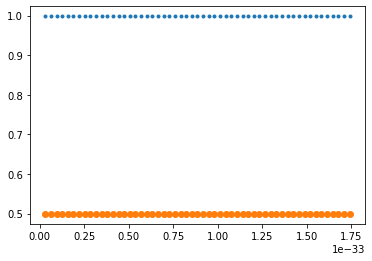

In [ ]:
#INITIAL WAVE PREPARATION
try:
    import openfermion
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq


from openfermion import FermionOperator
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

#1 fermion = 2 qubits
N = 2
N_qubits = 2 * N
J = 1

#----------------------------------------Operators Preparation-----------------------------------------------

n = np.array([[0,0], [0,1]])
I = np.eye(2)
I2 = np.eye(2**2)
I3 = np.eye(2**3)

# n1 = n ⊗ I ⊗ I ⊗ I, n2 = I ⊗ n ⊗ I ⊗ I
n1 = np.kron(n, I3)
n2 = np.kron( np.kron(I, n), I2)

#----------------------------------------Initial Wavefunction-----------------------------------------------
  
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]

#only spin up, with coefficients drawn from a gaussian
L = 4
m = 4.5
sigma = 1

epsilon = [-4 * np.random.normal(loc = m,  scale = sigma) for i in range(N)]
H_epsilon = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0)), coefficient = epsilon[int(i/2)]
               )
          for i in range(0, N_qubits, 2)
       )
]

#Initial Hamiltonian
H_initial = sum(H_J) + sum(H_epsilon)
sparse_init = of.get_sparse_operator(H_initial)
eigs, eigvec = scipy.sparse.linalg.eigsh(sparse_init, k = 1)

#Starting wavefunction, if you want to use fqe see previous code and copy paste here
initial_wave = eigvec[:, 0]



#----------------------------------------Time Evolution with Trotter Steps, using scipy.sparse-----------------------------------------------


#J already specified
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]

U = 1.
H_U = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U  
               )
          for i in range(0, N_qubits, 2)
       )
]

#THINK ABOUT dt CHOICE BETTER
dt = 1.05457182e-34 * 0.3 / J
trotter_steps = 55


#Trotter steps, exp of U and J separatedely
hop =  sum(H_J)
coulomb = sum(H_U)

#loop initialization
wave = initial_wave
t = 0
n1_t = []      #n1 at time t
n2_t = []
times = []


for step in range(trotter_steps):

  #expm_multiply avoids storing the matrices, which are very big for 8 qubits 
  wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(hop) * dt, wave)
  wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(coulomb) * dt, wave)

  n1_t.append(wave @ n1 @ wave)
  n2_t.append(wave @ n2 @ wave)

  #print(wave @ n1 @ wave)

  t += dt
  times.append(t)

charge = [a + b for (a, b) in(zip(n1_t, n2_t)) ]
spin =  [a - b for (a, b) in(zip(n1_t, n2_t)) ]

#plt.plot(times, charge, '.')
#plt.plot(times, spin, 'o')
plt.plot(times, n1_t, '.')
plt.plot(times, n2_t, 'o')


In [ ]:
# 4 qubits = 2 fermion testing
try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

import numpy as np


n = np.array([[0,0], [0,1]])
I = np.eye(2)
I2 = np.eye(2**2)
I3 = np.eye(2**3)

# n1 = n ⊗ I ⊗ I ⊗ I, n2 = I ⊗ n ⊗ I ⊗ I
n1 = np.kron(n, I3)
n2 = np.kron( np.kron(I, n), I2)

#A circuit is made from operations. You can define 20 qubits, but if you do operations only on 2 of them, your circuit will have those and a 4 by 1 state!
up, down, q3, q4 = cirq.LineQubit.range(4)
circuit = cirq.Circuit([cirq.Z(up), cirq.Z(down), cirq.Z(up), cirq.Z(down), cirq.Z(q3), cirq.Z(q3), cirq.Z(q4), cirq.Z(q4)])
sim = cirq.Simulator()

print(circuit)

#0b PRIMO SITO (più significato), SECONDO SITO (meno significativo)
result = sim.simulate(circuit, initial_state = 0b1001)
simulated_state = result.final_state_vector

print(simulated_state)

print(simulated_state @ n1 @ simulated_state)

0: ───Z───Z───

1: ───Z───Z───

2: ───Z───Z───

3: ───Z───Z───
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
(1+0j)


# Check Initial State Correctedness

dict_keys([(3, 1)])


Text(0, 0.5, 'Spin density $\\rho^-$')

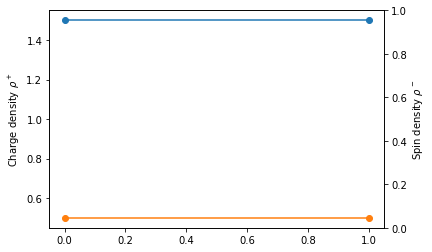

In [ ]:
#INITIAL WAVE PREPARATION
try:
    import openfermion
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe


from openfermion import FermionOperator
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

#1 fermion = 2 qubits
N = 2
N_qubits = 2 * N
J = 1

#----------------------------------------Operators Preparation-----------------------------------------------

n = np.array([[0,0], [0,1]])
I = np.eye(2)
I2 = np.eye(2**2)
I3 = np.eye(2**3)

# n1 = n ⊗ I ⊗ I ⊗ I, n2 = I ⊗ n ⊗ I ⊗ I
n1 = np.kron(n, I3)
n2 = np.kron( np.kron(I, n), I2)

#----------------------------------------Initial Wavefunction-----------------------------------------------
  
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]

#only spin up, with coefficients drawn from a gaussian
L = 4
m = 4.5
sigma = 1

epsilon = [-4 * np.random.normal(loc = m,  scale = sigma) for i in range(N)]
H_epsilon = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0)), coefficient = epsilon[int(i/2)]
               )
          for i in range(0, N_qubits, 2)
       )
]

#Initial Hamiltonian
H_initial = sum(H_J) + sum(H_epsilon)
sparse_init = of.get_sparse_operator(H_initial)
eigs, eigvec = scipy.sparse.linalg.eigsh(sparse_init, k = 1)

#Starting wavefunction, if you want to use fqe see previous code and copy paste here
initial_wave = eigvec[:, 0]
fqe_init_wave = fqe.from_cirq(initial_wave, thresh = 1e-12)

print(fqe_init_wave.sectors())

print(fqe_init_wave)

#copy pasted operators, did some magic with dictionary keys
opdm_a, opdm_b = fqe_init_wave.sector((3, 1)).get_spin_opdm()
charge_density = np.diagonal(opdm_a).real + np.diagonal(opdm_b).real
spin_density = np.diagonal(opdm_a).real - np.diagonal(opdm_b).real

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
plt.plot(np.arange(len(charge_density)), charge_density, "-o", label="Charge")
plt.plot(np.arange(len(charge_density)), spin_density, "-o", label="Spin")

# Axes.
ax.set_ylabel(r"Charge density $\rho^+$")
ax_twin = ax.twinx()
ax_twin.set_ylabel(r"Spin density $\rho^-$")





In [ ]:
dict_keys([(3, 1)])

In [ ]:
#INITIAL WAVE PREPARATION
try:
    import openfermion
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe


from openfermion import FermionOperator
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

#1 fermion = 2 qubits
N = 2
N_qubits = 2 * N
J = 1 #I think they are using J = -1

#----------------------------------------Operators Preparation-----------------------------------------------

n = np.array([[0,0], [0,1]])
I = np.eye(2)
I2 = np.eye(2**2)
I3 = np.eye(2**3)

# n1 = n ⊗ I ⊗ I ⊗ I, n2 = I ⊗ n ⊗ I ⊗ I
n1 = np.kron(n, I3)
n2 = np.kron( np.kron(I, n), I2)
n1down = np.kron( I2, np.kron(n, I))
n2down = np.kron(I3, n)

#----------------------------------------Initial Wavefunction-----------------------------------------------
  
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]

#only spin up, with coefficients drawn from a gaussian
L = 4
m = 4.5
sigma = 1

epsilon = [-4 * np.random.normal(loc = m,  scale = sigma) for i in range(N)]
H_epsilon = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0)), coefficient = epsilon[int(i/2)]
               )
          for i in range(0, N_qubits, 2)
       )
]

#Initial Hamiltonian
H_initial = sum(H_J) + sum(H_epsilon)
sparse_init = of.get_sparse_operator(H_initial)
eigs, eigvec = scipy.sparse.linalg.eigsh(sparse_init, k = 1)

#Starting wavefunction, if you want to use fqe see previous code and copy paste here
initial_wave = eigvec[:, 0]
print(sum(i*np.conj(i) for i in initial_wave))

n = [n1, n1down, n2, n2down]
sites = np.arange(len(n)//2)
charge = []
spin = []
for i in range(0,len(n),2):
  nup = initial_wave @ n[i] @initial_wave
  ndown = initial_wave @ n[i+1] @initial_wave
  charge.append(nup + ndown)
  spin.append(nup - ndown)

plt.plot(sites, charge, 'o')
plt.plot(sites, spin, 'o')



In [ ]:
# Parameters used in the Fermi-Hubbard experiment.
nsites = 8
l_up = 4
m_up = 4.5
sigma_up = 1

# For convenience.
site_index = np.arange(1, nsites + 1)

# Creating the spin-up and spin-down Hamiltonians.
spin_up_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)
spin_up_ham += np.diag(-l_up * np.exp(-0.5 * (site_index - m_up)**2) / sigma_up**2)
spin_down_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)

print(spin_down_ham)

In [ ]:
N = 2
N_qubits = 2*N

a = np.matrix(([0, 1], [0, 0]))
a_dagger = a.T
sigma_z = np.matrix(([1,0], [0,-1]))

kill_op = []
  # a1 = a ⊗ I(2**(N_qubits-1)), n2 = sigma_z ⊗ a ⊗ I(2**(N_qubits -1 -1)), ..., ni = sigma_z^i ⊗ a ⊗ I(2**(N_qubits -1 -i))

for i in range(N_qubits):
  operator = a
  # sigma_z^i ⊗ a, adding sigma_z to the left i times
  for j in range(i):
    operator = np.kron(sigma_z, operator)
 
  operator = np.kron(operator, np.eye(2**(N_qubits-1-i)))  #I(2**N-1-i) to the right
  assert(operator.shape[0] == 2**(N_qubits)) #check dimension

  #YOU COULD USE SPARSE HERE AND MAKE CODE BETTER
  kill_op.append(operator)

#create a list of creation operators in matrix form
born_op = []
for el in kill_op:
  born_op.append(el.H) #no need for Hermitian conjugate in this representation
  

n_op = [c * d for (c,d) in zip(born_op, kill_op)] #c = create, d = destruct

n1_to_check = np.kron(a_dagger @ a, np.eye(2**(N_qubits -1)))
assert((n_op[0] == n1_to_check).all())

#
J = 1
U = 1

H_J = []
#sum_j sum_nu for j in [1, L-1] when I have L = N sites, separating nu = up from down
for i in range(0, N - 1 , 2):
  H_J.append(-J*np.matrix(born_op[i]) @ np.matrix(kill_op[i+1]))
for i in range(1, N - 1 , 2):
  H_J.append(-J*np.matrix(born_op[i]) @ np.matrix(kill_op[i+1]))

#+ h.c
for element in H_J:
  H_J.append(element.H)

print(sum(H_J))



#fallo con openfermion e sparse

# Openfermion coincide con il metodo a mano

In [ ]:
try:
    import openfermion as of
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

from openfermion import FermionOperator

import numpy as np
from scipy.sparse import csr_matrix

N = 4
N_qubits = 2*N

a = np.matrix(([0, 1], [0, 0]))
a_dagger = a.T
sigma_z = np.matrix(([1,0], [0,-1]))

kill_op = []
  # a1 = a ⊗ I(2**(N_qubits-1)), n2 = sigma_z ⊗ a ⊗ I(2**(N_qubits -1 -1)), ..., ni = sigma_z^i ⊗ a ⊗ I(2**(N_qubits -1 -i))

for i in range(N_qubits):
  operator = a
  # sigma_z^i ⊗ a, adding sigma_z to the left i times
  for j in range(i):
    operator = np.kron(sigma_z, operator)
 
  operator = np.kron(operator, np.eye(2**(N_qubits-1-i)))  #I(2**N-1-i) to the right
  assert(operator.shape[0] == 2**(N_qubits)) #check dimension

  #YOU COULD USE SPARSE HERE AND MAKE CODE BETTER
  kill_op.append(operator)

#create a list of creation operators in matrix form
born_op = []
for el in kill_op:
  born_op.append(el.H) #no need for Hermitian conjugate in this representation
  

n_op = [c * d for (c,d) in zip(born_op, kill_op)] #c = create, d = destruct

n1_to_check = np.kron(a_dagger @ a, np.eye(2**(N_qubits -1)))
assert((n_op[0] == n1_to_check).all())

kill_op = [csr_matrix(el) for el in kill_op]
born_op = [csr_matrix(el) for el in born_op]
n_op = [csr_matrix(el) for el in n_op]

#
J = 1


H_J = []
#sum_j sum_nu for j in [1, L-1] when I have L = N sites, separating nu = up from down
for i in range(0, 2*N - 2 , 2):
  H_J.append(-J*born_op[i] @ kill_op[i+2])
  H_J.append(-J*born_op[i+2] @ kill_op[i])   #hermitian conjugated
for i in range(1, 2*N - 2 , 2):
  H_J.append(-J*born_op[i] @ kill_op[i+2])
  H_J.append(-J*born_op[i+2] @ kill_op[i])


#print(csr_matrix.todense(sum(H_J)))
#print(np.count_nonzero(np.array(csr_matrix.todense(sum(H_J)))))
hopping_term = csr_matrix.todense(sum(H_J))

#------------------------------------------------------------------------------------------------------------------------------------------------------
#CHECK: matrix coincides with openfermion ones
H_J_of = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]

#print(of.get_sparse_operator(sum(H_J_of)).todense().real)
assert(of.get_sparse_operator(sum(H_J_of)).todense().real == csr_matrix.todense(sum(H_J)) ).all()
#-------------------------------------------------------------------------------------------------------------------------------------------------------
#----------- U matrix-------------------------------------------------------------------------------

U = 1
H_U = []
for i in range(0,N):
  H_U.append(U*n_op[2*i] @ n_op[2*i+1])

coulomb_term = (csr_matrix.todense(sum(H_U)))


#openfermion version

H_U_of = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U  
               )
          for i in range(0, N_qubits, 2)
       )
]

assert((of.get_sparse_operator(sum(H_U_of)).todense().real == csr_matrix.todense(sum(H_U))).all())


#------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------Interaction potential---------------------------------------------------------------
L = 4
m = 4.5
sigma = 1

#do it only for the up qubits
epsilon = [-4 * np.exp( 0.5 * ((i+1)-m)**2 / sigma**2  ) for i in range(N)]
H_epsilon = []

#construct sum epsilon * n_i on up; n_op has the right expression for considering the whole qubit set (also down, from a tensor prod with I)
for i in range(0, N_qubits, 2):
  H_epsilon.append(epsilon[i//2] * n_op[i])

local_potential =  (csr_matrix.todense(sum(H_epsilon)))
assert(local_potential.shape[0] == 2**N_qubits)

#this would lack down qubits however, we made the checks by hand with epsilon = [1,1] and local_potential = n0 + n2 = diag(0,0,1,1 ; 0,0,1,1 ; 1,1,2,2 ; 1,1,2,2)
#H_epsilon_of = [op  for op in 
#      (FermionOperator(
#               ((i,1), (i,0)), coefficient = epsilon[int(i/2)])
#          for i in range(0, N_qubits, 2))]



#one could confront the sparse matrices to gain computation time

#https://github.com/quantumlib/OpenFermion-FQE/blob/v0.1.0/src/fqe/wavefunction.py#L47-L1286
# first 3 parameters: number of fermionic particles, z component of angular momentum, number of spatial orbitals

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe

"""
What follows prints 
Sector N = 2 : S_z = 0
a'0001'b'0001' (1+0j)
where N, with hartree-fock, is how many ones there are, and N_qubits = 4 gives 0001, there would be 8 qubits for up and down for #orbitals = N_qubits = 8
"""
init_wave = fqe.Wavefunction([[N, 0, N_qubits]])
init_wave.set_wfn(strategy = 'hartree-fock')
init_wave.print_wfn() 

#this would give the lowest state for Nup = Ndown = 2, IF the Hamiltonian was diagonal/ that of an harmonic oscillator, which can use creation
#and annihilation operators directly

_, eigvec = np.linalg.eigh(hopping_term + local_potential)   #eigenvectors of the system


print(fqe.to_cirq(init_wave))

assert np.isclose(np.linalg.norm(fqe.to_cirq(init_wave)), 1)



-1938.707962635176 [-6.70230777e-18 -7.64652255e-18  3.70383807e-17 -4.56985102e-17
 -5.11788225e-18 -2.12122713e-17 -1.21961527e-17  3.70381893e-17
  2.29310468e-18  8.29366249e-18  2.34884867e-19 -6.09490161e-18
  7.92410901e-18  3.75077067e-18  2.00635009e-17  1.91775787e-17
  3.00461063e-18  3.76929462e-17 -2.63399559e-18  2.92406887e-17
 -6.40466928e-17 -1.69184314e-18 -2.22928940e-17 -4.15092998e-17
 -8.50588416e-18 -3.34146111e-18 -4.36262598e-18 -4.81885065e-17
 -3.54482619e-18 -1.16691550e-17  4.36269757e-17  6.30587898e-18
  1.33954064e-19  5.54122279e-18  1.73203895e-17 -7.13090987e-18
  7.50997007e-18  2.82340279e-18 -2.38322982e-17 -1.23487469e-17
  2.55827828e-18 -1.21692309e-17 -6.97947523e-18  2.23366768e-18
  1.71902291e-17 -5.61955156e-18 -3.82760784e-18 -1.01920629e-17
  6.66154392e-18 -2.43611592e-17 -4.59962917e-17 -8.38228971e-18
  6.69200256e-18  1.37036327e-18 -4.81514690e-17  4.18335701e-17
  1.96421318e-17 -1.06203546e-16  7.69843331e-19  3.89032437e-17
  9.60

In [ ]:
#Attempt, before using fqe, now that the Interaction Operator has the correct form and does not cover only up
import scipy.sparse
import matplotlib.pyplot as plt

H_init = local_potential + hopping_term

#eigs, eigvec = scipy.sparse.linalg.eigsh(csr_matrix.todense(H_init), k = 1)
_, eigvec = np.linalg.eigh((H_init))

#Starting wavefunction, if you want to use fqe see previous code and copy paste here
initial_wave = eigvec[:, 0]  #this is a matrix object! So you have to transpose it, unlike np arrays

print(initial_wave, len(initial_wave), sum(initial_wave.T @ initial_wave))

sites = np.arange(N)
charge = []
spin = []
for i in range(0,N_qubits,2):
  nup =  initial_wave.H @ n_op[i] @ initial_wave
  ndown = initial_wave.H @ n_op[i+1] @initial_wave
  charge.append(nup + ndown)
  spin.append(nup - ndown)

#print(np.squeeze(np.asarray(charge)))

#access the value from 1 dim matrix (they really should get rid of matrix and keep array)
charge = [mat.item() for mat in charge]
spin = [mat.item() for mat in spin]

plt.plot(sites, charge, 'o')
plt.plot(sites, spin, 'o')

#Doesn't work: let's try FQE
#You should understand why: look at the wavefunction, not done it yet

NameError: ignored

In [ ]:
                    #WRONG MATRICES FROM THE NOTEBOOK

# Parameters used in the Fermi-Hubbard experiment.
nsites = 8
l_up = 4
m_up = 4.5
sigma_up = 1

# For convenience.
site_index = np.arange(1, nsites + 1)



# Creating the spin-up and spin-down Hamiltonians.
spin_up_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)
spin_up_ham += np.diag(-l_up * np.exp(-0.5 * (site_index - m_up)**2) / sigma_up**2)
spin_down_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)

print(spin_up_ham, spin_down_ham)


# Initialize wavefunction to occupy the two lowest states.
init_wfn = fqe.Wavefunction([[nsites // 2, 0, nsites]])
init_wfn.set_wfn(strategy='hartree-fock')
init_wfn.print_wfn()

_, v_up = np.linalg.eigh(spin_up_ham)
_, v_down = np.linalg.eigh(spin_down_ham)

from fqe.algorithm.low_rank import evolve_fqe_givens_sector


init_wfn = evolve_fqe_givens_sector(init_wfn, v_up, sector='alpha')
#init_wfn.print_wfn()
init_wfn = evolve_fqe_givens_sector(init_wfn, v_down, sector='beta')
#init_wfn.print_wfn()


#qui spiega questo benedetto givens

[[-0.00874996 -1.          0.          0.          0.          0.
   0.          0.        ]
 [-1.         -0.17574773 -1.          0.          0.          0.
   0.          0.        ]
 [ 0.         -1.         -1.29860987 -1.          0.          0.
   0.          0.        ]
 [ 0.          0.         -1.         -3.52998761 -1.          0.
   0.          0.        ]
 [ 0.          0.          0.         -1.         -3.52998761 -1.
   0.          0.        ]
 [ 0.          0.          0.          0.         -1.         -1.29860987
  -1.          0.        ]
 [ 0.          0.          0.          0.          0.         -1.
  -0.17574773 -1.        ]
 [ 0.          0.          0.          0.          0.          0.
  -1.         -0.00874996]] [[ 0. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.]
 [

# Segnalibro

Using fqe and the correct Hamiltonians

     |████████████████████████████████| 1.8 MB 28.1 MB/s 
     |████████████████████████████████| 541 kB 54.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 409 kB 27.0 MB/s 
     |████████████████████████████████| 3.1 MB 53.8 MB/s 
     |████████████████████████████████| 131 kB 50.6 MB/s 
     |████████████████████████████████| 1.5 MB 62.0 MB/s 
     |████████████████████████████████| 1.3 MB 46.3 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 121 kB 79.6 MB/s 
     |████████████████████████████████| 100 kB 10.2 MB/s 
     |██████████████████████

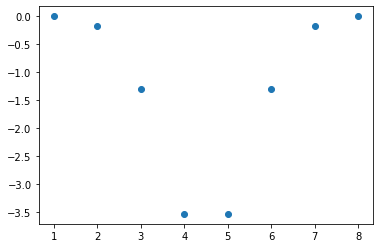

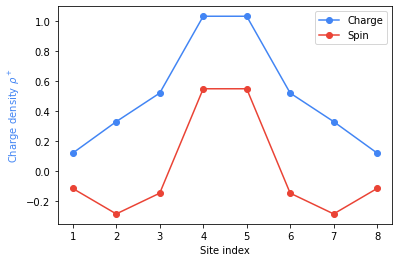

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import openfermion as of
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe

from openfermion import FermionOperator
from fqe.algorithm.low_rank import evolve_fqe_givens_sector

N = 8
N_qubits = 2*N


#------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------Hopping term-------------
J = 1.
hopping_fqe = np.diag([-J]*(N-1), k = 1) + np.diag([-J]*(N-1), k = -1)   #k is offset from diagonal

#------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------Interaction potential---------------------------------------------------------------
L = 4
m = 4.5
sigma = 1

#do it only for the up qubits
sites = np.arange(1, N+1)
potential_fqe = np.diag([-L * np.exp( -0.5 * 
                                (site-m)**2 / sigma**2  ) for site in sites
                   ])

#to visualize potential; slows code
plt.plot(sites, np.diag(potential_fqe), 'o')


#-------------------------------------------------------------------------------------------------------------
#------------------------------------- WAVEFUNCTION INITIALIZATION--------------------------------------------



#https://github.com/quantumlib/OpenFermion-FQE/blob/v0.1.0/src/fqe/wavefunction.py#L47-L1286
# first 3 parameters: number of fermionic particles, z component of angular momentum, number of spatial orbitals
"""
What follows, init_wave = fqe.Wavefunction([[N, 0, N2]]),  prints 
Sector N = 2 : S_z = 0
a'0001'b'0001' (1+0j)
where N, with hartree-fock, is how many ones there are, and N2 = 4 gives 0001, there would be 8 qubits for up and down for #orbitals = N2 = 8
"""
init_wave = fqe.Wavefunction([[N//2, 0, N]])
init_wave.set_wfn(strategy = 'hartree-fock')
init_wave.print_wfn() 

#this would give the lowest state for Nup = Ndown = 2, IF the Hamiltonian was diagonal/ that of an harmonic oscillator, which can use creation
#and annihilation operators directly

ham_down = hopping_fqe
ham_up = ham_down + potential_fqe


#the fermion operator gets digested into fqe excitation operator g for H = eps (g + g^\dagger)
#init_wave.time_evolve(1.0, ham_up)
#init_wave.print_wfn()   #nothing seems to change 


_, eig_up = np.linalg.eigh(ham_up)
_, eig_down = np.linalg.eigh(ham_down)

#Rotate |00...011> |00...011> set for a diagonal hamiltonian to the system initial state 
init_wave = evolve_fqe_givens_sector(init_wave, eig_up, sector='alpha')
init_wave = evolve_fqe_givens_sector(init_wave, eig_down, sector='beta')

#check normalization
assert np.isclose(np.linalg.norm(fqe.to_cirq(init_wave)), 1)

#.get_spin_opdm gets the spin of the subsystems/blocks of spins alfa and beta
# https://github.com/quantumlib/OpenFermion-FQE/blob/v0.1.0/src/fqe/fqe_data.py#L1789-L1794
# https://physics.stackexchange.com/questions/338118/one-body-reduced-density-matrix
# which calculates spins using https://github.com/quantumlib/OpenFermion-FQE/blob/v0.1.0/src/fqe/fqe_data.py#L1274-L1283

opdm_a, opdm_b = init_wave.sector((N // 2, 0)).get_spin_opdm()        #get N = 4, S_z = 0 sector
charge_density = np.diagonal(opdm_a).real + np.diagonal(opdm_b).real  #get the diagonal of each reduced density matrix, because it contains the populations. They are real
spin_density = np.diagonal(opdm_a).real - np.diagonal(opdm_b).real

#charge and angular momentum conservation
assert np.isclose(sum(charge_density), 4)
assert np.isclose(sum(spin_density), 0)

#the 1RDM doesn't have trace 1: it's like the spin is "1" instead of hbar/2
print(np.trace(opdm_a)) #this is two


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
colors = ['#4285F4', '#EA4335']
plt.plot(sites, charge_density, "-o", color=colors[0], label="Charge")
plt.plot(sites, spin_density, "-o", color=colors[1], label="Spin")

ax.set_ylabel(r"Charge density $\rho^+$", color=colors[0])
ax.set_xlabel("Site index")
ax.legend();


In [ ]:
#print(init_wave.sector((N // 2, 0)))
#print( np.diagonal(opdm_a))
#print(np.diagonal(opdm_a).real @ np.diagonal(opdm_a).real)
#print(np.trace(opdm_a), np.trace((0.5*opdm_a)**2))
#print(np.trace(opdm_b), np.trace((0.5*opdm_b)**2))

#print(sum(charge_density), sum(spin_density))



init_wave = fqe.Wavefunction([[6, 0, N]])
init_wave.set_wfn(strategy = 'hartree-fock')
init_wave.print_wfn() 

opdm_a, opdm_b = init_wave.sector((6, 0)).get_spin_opdm()        #get N = 4, S_z = 0 sector
charge_density = np.diagonal(opdm_a).real + np.diagonal(opdm_b).real  #get the diagonal of each reduced density matrix, because it contains the populations. They are real
spin_density = np.diagonal(opdm_a).real - np.diagonal(opdm_b).real

print('-------------------------------------------------------------'*7)
print(opdm_a, opdm_b)
print(np.trace(opdm_a), np.trace((opdm_a)**2))
print(np.trace(opdm_b), np.trace((opdm_b)**2))

Sector N = 6 : S_z = 0
a'00000111'b'00000111' (1+0j)
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]] [[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.


## Our result and time evolution tinkering




     |████████████████████████████████| 1.8 MB 5.6 MB/s 
     |████████████████████████████████| 541 kB 43.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 409 kB 5.2 MB/s 
     |████████████████████████████████| 3.1 MB 46.3 MB/s 
     |████████████████████████████████| 131 kB 49.9 MB/s 
     |████████████████████████████████| 1.5 MB 48.5 MB/s 
     |████████████████████████████████| 1.3 MB 41.2 MB/s 
     |████████████████████████████████| 100 kB 8.6 MB/s 
     |████████████████████████████████| 90 kB 8.4 MB/s 
     |████████████████████████████████| 121 kB 54.3 MB/s 
     |█████████████████████████

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


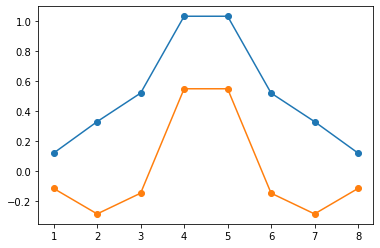

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import openfermion as of
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe

from openfermion import FermionOperator
from fqe.algorithm.low_rank import evolve_fqe_givens_sector

N = 8
N_qubits = 2*N


#------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------Hopping term-------------
J = 1.
hopping_fqe = np.diag([-J]*(N-1), k = 1) + np.diag([-J]*(N-1), k = -1)   #k is offset from diagonal

#------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------Interaction potential---------------------------------------------------------------
L = 4
m = 4.5
sigma = 1

#do it only for the up qubits
sites = np.arange(1, N+1)
potential_fqe = np.diag([-L * np.exp( -0.5 * 
                                (site-m)**2 / sigma**2  ) for site in sites
                   ])

#to visualize potential; slows code
#plt.plot(sites, np.diag(potential_fqe), 'o')


#-------------------------------------------------------------------------------------------------------------
#------------------------------------- WAVEFUNCTION INITIALIZATION--------------------------------------------



#https://github.com/quantumlib/OpenFermion-FQE/blob/v0.1.0/src/fqe/wavefunction.py#L47-L1286
# first 3 parameters: number of fermionic particles, z component of angular momentum, number of spatial orbitals
"""
What follows, init_wave = fqe.Wavefunction([[N, 0, N2]]),  prints 
Sector N = 2 : S_z = 0
a'0001'b'0001' (1+0j)
where N, with hartree-fock, is how many ones there are, and N2 = 4 gives 0001, there would be 8 qubits for up and down for #orbitals = N2 = 8
"""
init_wave = fqe.Wavefunction([[N//2, 0, N]])
init_wave.set_wfn(strategy = 'hartree-fock')
init_wave.print_wfn() 

#this would give the lowest state for Nup = Ndown = 2, IF the Hamiltonian was diagonal/ that of an harmonic oscillator, which can use creation
#and annihilation operators directly

ham_down = hopping_fqe
ham_up = ham_down + potential_fqe


#the fermion operator gets digested into fqe excitation operator g for H = eps (g + g^\dagger)
#init_wave.time_evolve(1.0, ham_up)
#init_wave.print_wfn()   #nothing seems to change 


_, eig_up = np.linalg.eigh(ham_up)
_, eig_down = np.linalg.eigh(ham_down)

#Rotate |00...011> |00...011> set for a diagonal hamiltonian to the system initial state 
init_wave = evolve_fqe_givens_sector(init_wave, eig_up, sector='alpha')
init_wave = evolve_fqe_givens_sector(init_wave, eig_down, sector='beta')


#check normalization
assert np.isclose(np.linalg.norm(fqe.to_cirq(init_wave)), 1)

#---------------------------------------------------------------------------------------------------------------------------
#to cirq; apparatus to express operators
initial = fqe.to_cirq(init_wave)


import scipy
from scipy import sparse

# n = [0 0]
#     [0 1]
# n tprod I ends in a diagonal [0,0 | 1,1] and other I to the right keeps doubling 0s and 1s separatedely. I tprod n ends in [0,1 | 0,1], doubling the given list
nops = []
for i in range(N_qubits):   #2*N to do it for all qubits
  i = int(i)
  diag = [0] * 2**(N_qubits-i-1) + [1] * 2**(N_qubits-i-1)
  diag = diag * 2**i
  nops.append(diag)

charge = []
spin = []
sites = np.arange(1,N+1)

print(len(initial), len(nops[0]))

for i in range(N):
  nup = ( np.conj(initial) * initial ) @ nops[2*i]
  ndown =( np.conj(initial) * initial ) @ nops[2*i + 1]

  charge.append(nup + ndown)
  spin.append(nup - ndown)

plt.plot(sites, charge, '-o')
plt.plot(sites, spin, '-o')

assert np.isclose(sum(charge), 4)
assert np.isclose(sum(spin), 0)

Time Evolution

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


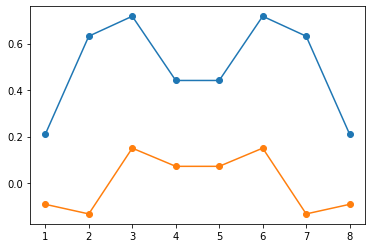

In [ ]:
#DIRECT TIME EVOLUTION

#hamiltonian of the systems which will evolve
U = 1.

H_J = [
       op + of.hermitian_conjugated(op) for op in 
       (
                       FermionOperator(((i,1), (i+2,0)), coefficient = -J ) 
                       for i in range(N_qubits - 2) )]
H_U = [
       op  for op in 
      (
          FermionOperator( ((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U )
          for i in range(0, N_qubits, 2) )]


hubbard_ham = sum(H_J) + sum(H_U)
time = 1.2

#e^(-iHt)
exact_state = scipy.sparse.linalg.expm_multiply(-1j * of.get_sparse_operator(hubbard_ham) * time, initial)

charge = []
spin = []

for i in range(N):
  nup = ( np.conj(exact_state) * exact_state ) @ nops[2*i]
  ndown =( np.conj(exact_state) * exact_state ) @ nops[2*i + 1]

  charge.append(nup + ndown)
  spin.append(nup - ndown)

plt.plot(sites, charge, '-o')
plt.plot(sites, spin, '-o')

assert np.isclose(sum(charge), 4)
assert np.isclose(sum(spin), 0)


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


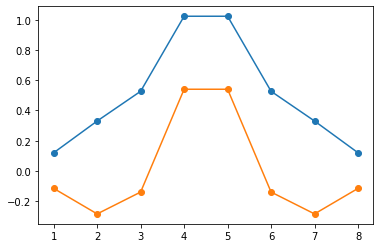

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


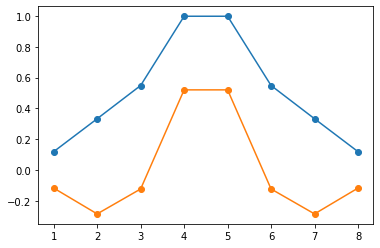

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


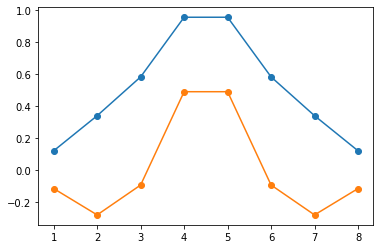

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


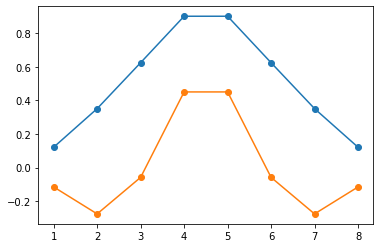

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


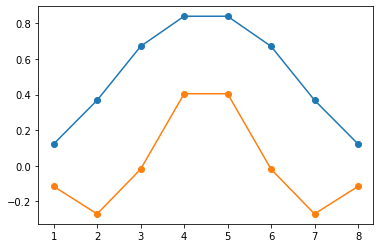

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


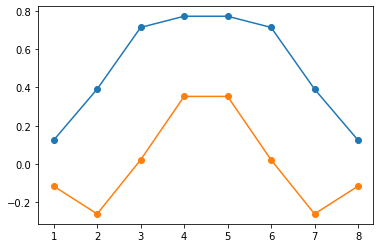

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


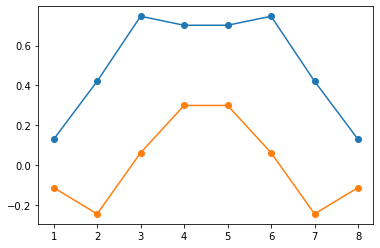

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


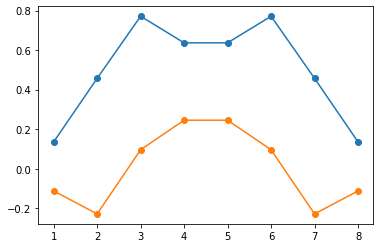

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


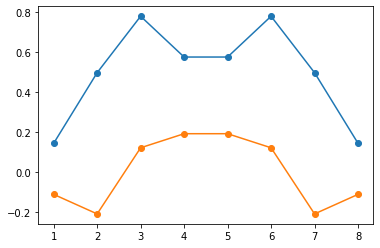

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


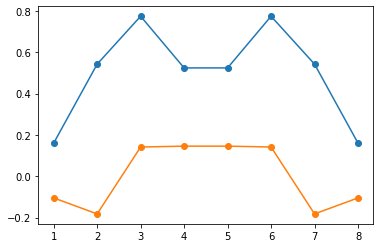

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


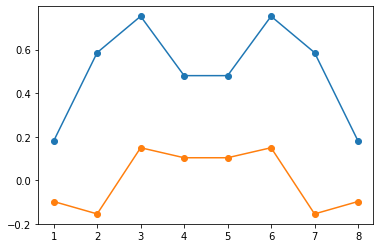

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


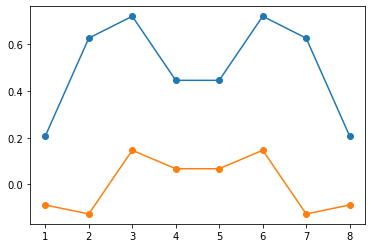

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


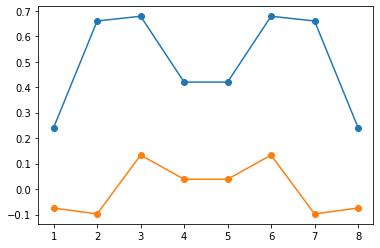

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


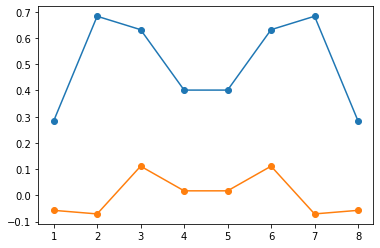

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


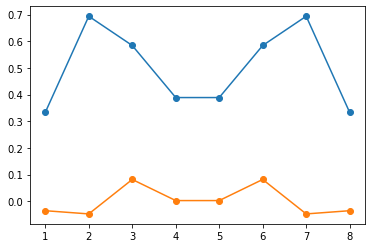

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


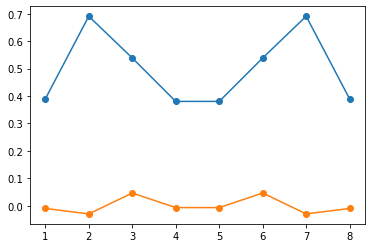

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


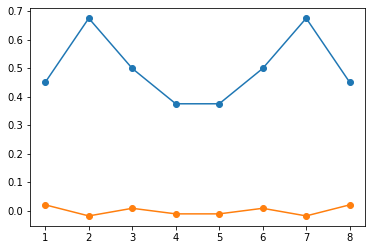

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


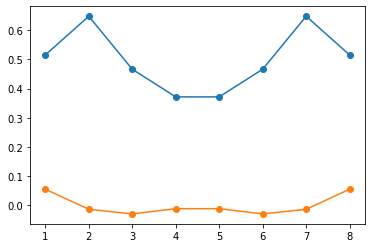

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


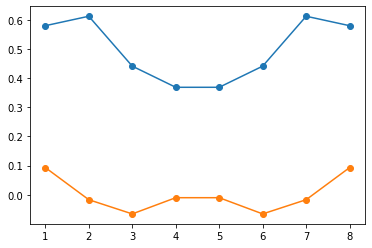

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


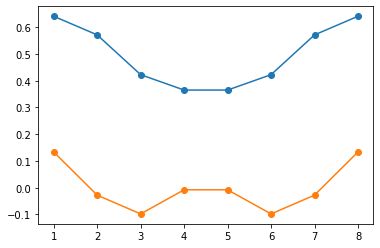

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


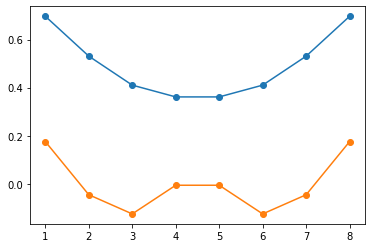

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


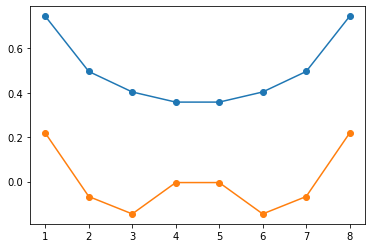

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


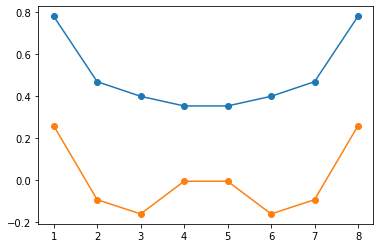

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


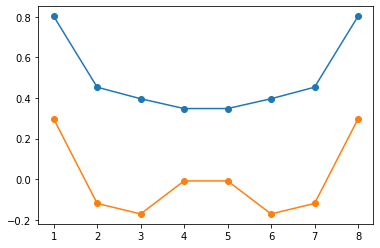

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


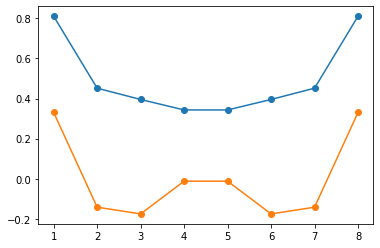

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


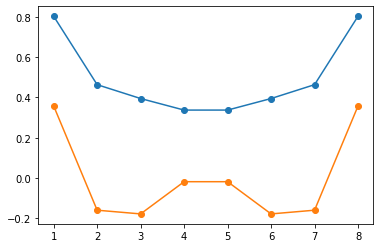

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


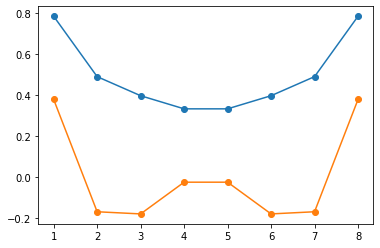

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


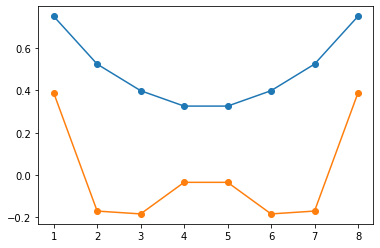

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


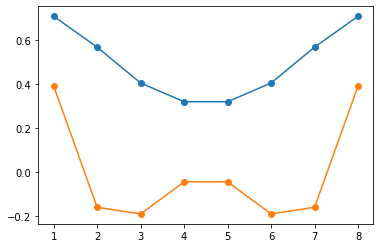

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


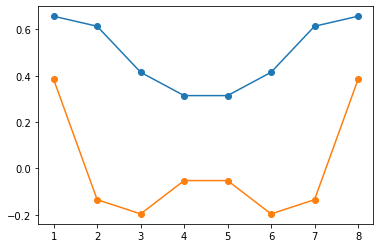

In [ ]:
#TROTTER
#hamiltonian of the systems which will evolve
U = 1.
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]
H_U = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U  
               )
          for i in range(0, N_qubits, 2)
       )
]

dt = 0.1
trotter_steps = 30

#do the trotter steps, with separated J and U terms exponentials
hop =  sum(H_J)
coulomb = sum(H_U)

#copy for the loop, keeping the wfn is also nice
wave = initial
t = 0

for step in range(trotter_steps):

  #you can't store the unitary separately with matrices this big 
  wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(hop) * dt, wave)
  wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(coulomb) * dt, wave)

  t += dt
  charge = []
  spin = []

  for i in range(N):
    nup = ( np.conj(wave) * wave ) @ nops[2*i]
    ndown =( np.conj(wave) * wave ) @ nops[2*i + 1]

    charge.append(nup + ndown)
    spin.append(nup - ndown)

  plt.plot(sites, charge, '-o')
  plt.plot(sites, spin, '-o')
  plt.show()

  assert np.isclose(sum(charge), 4)
  assert np.isclose(sum(spin), 0)

# Spread

Sector N = 4 : S_z = 0
a'00000011'b'00000011' (1+0j)
65536 65536


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


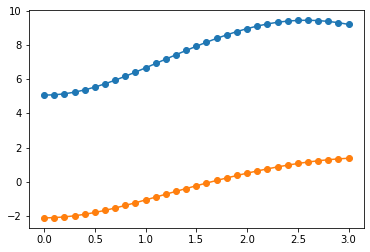

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


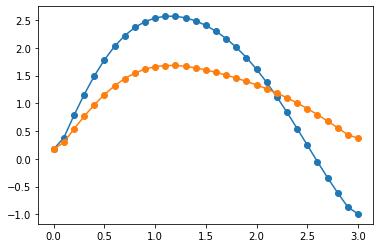

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import openfermion as of
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe

from openfermion import FermionOperator
from fqe.algorithm.low_rank import evolve_fqe_givens_sector

N = 8
N_qubits = 2*N


#------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------Hopping term-------------
J = 1.
hopping_fqe = np.diag([-J]*(N-1), k = 1) + np.diag([-J]*(N-1), k = -1)   #k is offset from diagonal

#------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------Interaction potential---------------------------------------------------------------
L = 4
m = 4.5
sigma = 1

#do it only for the up qubits
sites = np.arange(1, N+1)
potential_fqe = np.diag([-L * np.exp( -0.5 * 
                                (site-m)**2 / sigma**2  ) for site in sites
                   ])

#to visualize potential; slows code
#plt.plot(sites, np.diag(potential_fqe), 'o')


#-------------------------------------------------------------------------------------------------------------
#------------------------------------- WAVEFUNCTION INITIALIZATION--------------------------------------------



#https://github.com/quantumlib/OpenFermion-FQE/blob/v0.1.0/src/fqe/wavefunction.py#L47-L1286
# first 3 parameters: number of fermionic particles, z component of angular momentum, number of spatial orbitals
"""
What follows, init_wave = fqe.Wavefunction([[N, 0, N2]]),  prints 
Sector N = 2 : S_z = 0
a'0001'b'0001' (1+0j)
where N, with hartree-fock, is how many ones there are, and N2 = 4 gives 0001, there would be 8 qubits for up and down for #orbitals = N2 = 8
"""
init_wave = fqe.Wavefunction([[N//2, 0, N]])
init_wave.set_wfn(strategy = 'hartree-fock')
init_wave.print_wfn() 

#this would give the lowest state for Nup = Ndown = 2, IF the Hamiltonian was diagonal/ that of an harmonic oscillator, which can use creation
#and annihilation operators directly

ham_down = hopping_fqe
ham_up = ham_down + potential_fqe


#the fermion operator gets digested into fqe excitation operator g for H = eps (g + g^\dagger)
#init_wave.time_evolve(1.0, ham_up)
#init_wave.print_wfn()   #nothing seems to change 


_, eig_up = np.linalg.eigh(ham_up)
_, eig_down = np.linalg.eigh(ham_down)

#Rotate |00...011> |00...011> set for a diagonal hamiltonian to the system initial state 
init_wave = evolve_fqe_givens_sector(init_wave, eig_up, sector='alpha')
init_wave = evolve_fqe_givens_sector(init_wave, eig_down, sector='beta')


#check normalization
assert np.isclose(np.linalg.norm(fqe.to_cirq(init_wave)), 1)

#---------------------------------------------------------------------------------------------------------------------------
#to cirq; apparatus to express operators
initial = fqe.to_cirq(init_wave)


import scipy
from scipy import sparse

# n = [0 0]
#     [0 1]
# n tprod I ends in a diagonal [0,0 | 1,1] and other I to the right keeps doubling 0s and 1s separatedely. I tprod n ends in [0,1 | 0,1], doubling the given list
nops = []
for i in range(N_qubits):   #2*N to do it for all qubits
  i = int(i)
  diag = [0] * 2**(N_qubits-i-1) + [1] * 2**(N_qubits-i-1)
  diag = diag * 2**i
  nops.append(diag)

charge = []
spin = []
sites = np.arange(1,N+1)

print(len(initial), len(nops[0]))

for i in range(N):
  nup = ( np.conj(initial) * initial ) @ nops[2*i]
  ndown =( np.conj(initial) * initial ) @ nops[2*i + 1]

  charge.append(nup + ndown)
  spin.append(nup - ndown)



assert np.isclose(sum(charge), 4)
assert np.isclose(sum(spin), 0)

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------- SPREADING ---------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def spread(vec, N):
  """
  Calculate the spread of spin and charge, given a vector with their values for all N sites.
  Need ii+1 for the site index because numbering starts from 0 in python
  """
  spreading = 0
  for ii in range(N):
    spreading += abs( (ii+1) - (N+1)/2) * vec[ii]
  
  return spreading

#TROTTER
#hamiltonian of the systems which will evolve
U = 1.
H_J = [
       op + of.hermitian_conjugated(op) for op in (
                       FermionOperator(
                                      ((i,1), (i+2,0)), coefficient = -J
                                      ) 
                       for i in range(N_qubits - 2)
       )]
H_U = [
       op  for op in 
      (
          FermionOperator(
               ((i,1), (i,0), (i+1, 1), (i+1,0)), coefficient = U  
               )
          for i in range(0, N_qubits, 2)
       )
]

dt = 0.1
trotter_steps = 30

#do the trotter steps, with separated J and U terms exponentials
hop =  sum(H_J)
coulomb = sum(H_U)

#copy for the loop, keeping the wfn is also nice
wave = initial
t = 0
#you should put the initial values here; I'm going to put zero: is it true? I think so because we have a Gaussian
charge_spread = []
spin_spread = []
times = [0]
#step zero
charge_spread.append(spread(charge, N))
spin_spread.append(spread(spin, N))

for step in range(trotter_steps):

  #you can't store the unitary separately with matrices this big 
  wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(hop) * dt, wave)
  wave = scipy.sparse.linalg.expm_multiply(-1.j * of.get_sparse_operator(coulomb) * dt, wave)

  t += dt
  
  charge = []
  spin = []
  for i in range(N):
    nup = ( np.conj(wave) * wave ) @ nops[2*i]
    ndown =( np.conj(wave) * wave ) @ nops[2*i + 1]

    charge.append(nup + ndown)
    spin.append(nup - ndown)

  times.append(t)
  charge_spread.append(spread(charge, N))
  spin_spread.append(spread(spin, N))


plt.plot(times, charge_spread, '-o')
plt.plot(times, spin_spread, '-o')
plt.show()

plt.plot(times, np.gradient(charge_spread, dt), '-o')
plt.plot(times, np.gradient(spin_spread, dt), '-o')

plt.show()

# Initial State Preparation
Qual è il problema? Che Nup = Ndown = 2 e un certo spin totale (S_z = 0) diventano numeri quantici del problema, che rimane in questo settore.
FQE è fatto apposta per sfruttare le simmetrie: possiamo fare evolvere uno stato verso il ground state mantenendolo in questa parte piccola dello spazio di Hilbert

In [ ]:
try:
  import cirq
except ImportError:
  !pip install cirq --quiet

"""Gate K from unitary"""
class K_gate(cirq.Gate):
    def __init__(self, theta):
        super(K_gate, self)
        self.theta = theta

    def _num_qubits_(self):
        return 2
    
    def _unitary_(self):
        return np.array([
            [1.0, 0.0, 0.0,  0.0],
            [0.0,  np.cos(self.theta), -np.sin(self.theta)* 1.0j,  0.0],
            [0.0,  np.sin(self.theta)*1.0j, np.cos(self.theta),  0.0],
            [0.0,  0.0, 0.0, 1.0]
        ]) 
    
    def _circuit_diagram_info_(self, args):
        return f"K({self.theta})", "K"




# Tentativo di implementare il circuito del paper
Fallito perché i loro theta e phi sono scelti di volta in volta, quindi non posso garantire la conservazione della carica senza dati più completi.

Sector N = 4 : S_z = 0
a'00000011'b'00000011' (1+0j)
65536 65536
                  ┌───────────────────────────────────┐           ┌─────────────────────┐
0: ────K(0.783)────@───────────────────────────────────────────────────────────────────────────────────
       │           │
1: ────K───────────┼──────────────────────────────────────iSwap─────────────────────────────K(0.783)───
                   │                                      │                                 │
2: ────K(0.783)────┼──────@───────────────────────────────iSwap────@────────────────────────K──────────
       │           │      │                                        │
3: ────K───────────┼──────┼───────────────────────────────iSwap────┼────────────────────────K(0.783)───
                   │      │                               │        │                        │
4: ────K(0.783)────┼──────┼──────@────────────────────────iSwap────┼──────@─────────────────K──────────
       │           │      │      │             

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


AssertionError: ignored

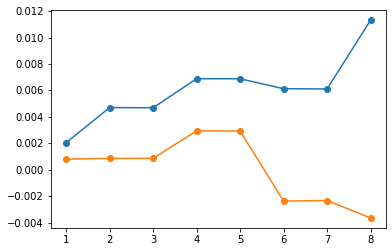

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

try:
    import openfermion as of
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe

from openfermion import FermionOperator
from fqe.algorithm.low_rank import evolve_fqe_givens_sector

N = 8
N_qubits = 2*N


#------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------Hopping term-------------
J = 1.
hopping_fqe = np.diag([-J]*(N-1), k = 1) + np.diag([-J]*(N-1), k = -1)   #k is offset from diagonal

#------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------Interaction potential---------------------------------------------------------------
L = 4
m = 4.5
sigma = 1

#do it only for the up qubits
sites = np.arange(1, N+1)
potential_fqe = np.diag([-L * np.exp( -0.5 * 
                                (site-m)**2 / sigma**2  ) for site in sites
                   ])

#to visualize potential; slows code
#plt.plot(sites, np.diag(potential_fqe), 'o')


#-------------------------------------------------------------------------------------------------------------
#------------------------------------- WAVEFUNCTION INITIALIZATION--------------------------------------------



#https://github.com/quantumlib/OpenFermion-FQE/blob/v0.1.0/src/fqe/wavefunction.py#L47-L1286
# first 3 parameters: number of fermionic particles, z component of angular momentum, number of spatial orbitals
"""
What follows, init_wave = fqe.Wavefunction([[N, 0, N2]]),  prints 
Sector N = 2 : S_z = 0
a'0001'b'0001' (1+0j)
where N, with hartree-fock, is how many ones there are, and N2 = 4 gives 0001, there would be 8 qubits for up and down for #orbitals = N2 = 8
"""
init_wave = fqe.Wavefunction([[N//2, 0, N]])
init_wave.set_wfn(strategy = 'hartree-fock')
init_wave.print_wfn() 

#this would give the lowest state for Nup = Ndown = 2, IF the Hamiltonian was diagonal/ that of an harmonic oscillator, which can use creation
#and annihilation operators directly

ham_down = hopping_fqe
ham_up = ham_down + potential_fqe


#the fermion operator gets digested into fqe excitation operator g for H = eps (g + g^\dagger)
#init_wave.time_evolve(1.0, ham_up)
#init_wave.print_wfn()   #nothing seems to change 


_, eig_up = np.linalg.eigh(ham_up)
_, eig_down = np.linalg.eigh(ham_down)

#Rotate |00...011> |00...011> set for a diagonal hamiltonian to the system initial state 
init_wave = evolve_fqe_givens_sector(init_wave, eig_up, sector='alpha')
init_wave = evolve_fqe_givens_sector(init_wave, eig_down, sector='beta')


#check normalization
assert np.isclose(np.linalg.norm(fqe.to_cirq(init_wave)), 1)

#---------------------------------------------------------------------------------------------------------------------------
#to cirq; apparatus to express operators
initial = fqe.to_cirq(init_wave)


import scipy
from scipy import sparse

# n = [0 0]
#     [0 1]
# n tprod I ends in a diagonal [0,0 | 1,1] and other I to the right keeps doubling 0s and 1s separatedely. I tprod n ends in [0,1 | 0,1], doubling the given list
nops = []
for i in range(N_qubits):   #2*N to do it for all qubits
  i = int(i)
  diag = [0] * 2**(N_qubits-i-1) + [1] * 2**(N_qubits-i-1)
  diag = diag * 2**i
  nops.append(diag)

charge = []
spin = []
sites = np.arange(1,N+1)

print(len(initial), len(nops[0]))

for i in range(N):
  nup = ( np.conj(initial) * initial ) @ nops[2*i]
  ndown =( np.conj(initial) * initial ) @ nops[2*i + 1]

  charge.append(nup + ndown)
  spin.append(nup - ndown)

assert np.isclose(sum(charge), 4)
assert np.isclose(sum(spin), 0)

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------  EXPERIMENTAL CIRCUIT               -----------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#insert angles theta and phi in Trotter step
theta = 0.783
phase = 0.138

a,b,c,d,e,f,g,h = cirq.LineQubit.range(8)
A,B,C,D,E,F,G,H = cirq.LineQubit.range(8,16)

up_spin = [a,b,c,d,e,f,g,h]
down_spin = [A,B,C,D,E,F,G,H]

N = len(up_spin) #8 fermions
circuit = cirq.Circuit()

#append 4 K gates in up spin fermions (0 to 7), then down spin ones (8 to 15), J odd in FIG.1 of paper
circuit.append(K_gate(theta)(up_spin[i], up_spin[i+1]) for i in range(N) if i%2 == 0)
circuit.append(K_gate(theta)(down_spin[i], down_spin[i+1]) for i in range(N) if i%2 == 0)

#append cphase (U odd), only coupling 0,2,4,6 (in the figure 1,3,5,7, justifying the name)
circuit.append(cirq.cphase(phase)(up_spin[i], down_spin[i]) for i in range(N-1) if i%2 == 0)

#append iSWAP coupling 1,2 - 3,4 - 5,6 and the same for spin down qubits
circuit.append(cirq.ISWAP(up_spin[i], up_spin[i+1]) for i in range(1, N-2) if i%2 == 1 )
circuit.append(cirq.ISWAP(down_spin[i], down_spin[i+1]) for i in range(1, N-2) if i%2 == 1 )

#cphase tra 2,4,6,7 e gli spin down corrispondenti

circuit.append(cirq.cphase(phase)(up_spin[i], down_spin[i]) for i in range(1,N-1) if i%2 == 0)
#tra ultimo ed ultimo, forse meno leggibile che con [7], visto che non devo riadattare
#visto che non sono coinvolti negli swap, cirq lo sposta a prima di questi in automatico
circuit.append(cirq.cphase(phase)(up_spin[N-1], down_spin[N-1])) 

#ultimo step, K tra 1,2 - 3,4 - 5,6
circuit.append(K_gate(theta)(up_spin[i], up_spin[i+1]) for i in range(N-2) if i%2 == 1)
circuit.append(K_gate(theta)(down_spin[i], down_spin[i+1]) for i in range(N-2) if i%2 == 1)

print(circuit)

#ordering up,down,up,down,... with ups on even sites, instead of a paper like order
qubits = []
for ii in range(N):
  qubits.append(up_spin[ii])
  qubits.append(down_spin[ii])

#simulation
simulator = cirq.Simulator()
result = simulator.simulate(circuit*4, qubit_order=qubits, initial_state=initial)
simulated_state = result.final_state_vector


#--------------------------PRINTING THINGS-----------------------------------------------------------------------------
nops = []
for i in range(N_qubits):   #2*N to do it for all qubits
  i = int(i)
  diag = [0] * 2**(N_qubits-i-1) + [1] * 2**(N_qubits-i-1)
  diag = diag * 2**i
  nops.append(diag)

charge = []
spin = []
sites = np.arange(1,N+1)


for i in range(N):
  nup = ( np.conj(simulated_state) * simulated_state) @ nops[2*i]
  ndown =( np.conj(simulated_state) * simulated_state ) @ nops[2*i + 1]

  charge.append(nup + ndown)
  spin.append(nup - ndown)

plt.plot(sites, charge, '-o')
plt.plot(sites, spin, '-o')

assert np.isclose(sum(charge), 4)
assert np.isclose(sum(spin), 0)

# Nup = Ndown = 3

Sector N = 6 : S_z = 0
a'00000111'b'00000111' (1+0j)
65536 65536


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


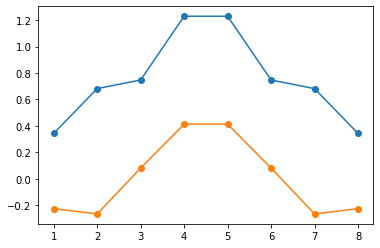

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import openfermion as of
except ImportError:
    !pip install -q git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion 
    import openfermion as of

try:
    import cirq
except ImportError:
    !pip install cirq --quiet
    import cirq

try:
    import fqe
except ImportError:
    # TODO: Change to `pip install fqe --quiet` when FQE>0.1.0 is released.
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet
    import fqe

from openfermion import FermionOperator
from fqe.algorithm.low_rank import evolve_fqe_givens_sector

N = 8
N_qubits = 2*N


#------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------Hopping term-------------
J = 1.
hopping_fqe = np.diag([-J]*(N-1), k = 1) + np.diag([-J]*(N-1), k = -1)   #k is offset from diagonal

#------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------Interaction potential---------------------------------------------------------------
L = 4
m = 4.5
sigma = 1

#do it only for the up qubits
sites = np.arange(1, N+1)
potential_fqe = np.diag([-L * np.exp( -0.5 * 
                                (site-m)**2 / sigma**2  ) for site in sites
                   ])

#to visualize potential; slows code
#plt.plot(sites, np.diag(potential_fqe), 'o')


#-------------------------------------------------------------------------------------------------------------
#------------------------------------- WAVEFUNCTION INITIALIZATION--------------------------------------------



#https://github.com/quantumlib/OpenFermion-FQE/blob/v0.1.0/src/fqe/wavefunction.py#L47-L1286
# first 3 parameters: number of fermionic particles, z component of angular momentum, number of spatial orbitals
"""
What follows, init_wave = fqe.Wavefunction([[2, 0, 4]]),  prints 
Sector N = 2 : S_z = 0
a'0001'b'0001' (1+0j)
where N = 2, with hartree-fock, is how many ones there are, and N2 = 4 leads to 0001 0001, there would be 8 qubits for up and down for #orbitals = N2 = 8
"""
init_wave = fqe.Wavefunction([[6, 0, N]])
init_wave.set_wfn(strategy = 'hartree-fock')
init_wave.print_wfn() 

#this would give the lowest state for Nup = Ndown = 2, IF the Hamiltonian was diagonal/ that of an harmonic oscillator, which can use creation
#and annihilation operators directly

ham_down = hopping_fqe
ham_up = ham_down + potential_fqe


#the fermion operator gets digested into fqe excitation operator g for H = eps (g + g^\dagger)
#init_wave.time_evolve(1.0, ham_up)
#init_wave.print_wfn()   #nothing seems to change 


_, eig_up = np.linalg.eigh(ham_up)
_, eig_down = np.linalg.eigh(ham_down)

#Rotate |00...011> |00...011> set for a diagonal hamiltonian to the system initial state 
init_wave = evolve_fqe_givens_sector(init_wave, eig_up, sector='alpha')
init_wave = evolve_fqe_givens_sector(init_wave, eig_down, sector='beta')


#check normalization
assert np.isclose(np.linalg.norm(fqe.to_cirq(init_wave)), 1)

#---------------------------------------------------------------------------------------------------------------------------
#to cirq; apparatus to express operators
initial = fqe.to_cirq(init_wave)


import scipy
from scipy import sparse

# n = [0 0]
#     [0 1]
# n tprod I ends in a diagonal [0,0 | 1,1] and other I to the right keeps doubling 0s and 1s separatedely. I tprod n ends in [0,1 | 0,1], doubling the given list
nops = []
for i in range(N_qubits):   #2*N to do it for all qubits
  i = int(i)
  diag = [0] * 2**(N_qubits-i-1) + [1] * 2**(N_qubits-i-1)
  diag = diag * 2**i
  nops.append(diag)

charge = []
spin = []
sites = np.arange(1,N+1)

print(len(initial), len(nops[0]))

for i in range(N):
  nup = ( np.conj(initial) * initial ) @ nops[2*i]
  ndown =( np.conj(initial) * initial ) @ nops[2*i + 1]

  charge.append(nup + ndown)
  spin.append(nup - ndown)

plt.plot(sites, charge, '-o')
plt.plot(sites, spin, '-o')

assert np.isclose(sum(charge), 6)
assert np.isclose(sum(spin), 0)